In [ ]:
import numpy as np
import pandas as pd
from google.colab import files
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
# Charger les données
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
data = pd.read_excel(file_name)



Saving Copie de data(1).xlsx to Copie de data(1) (2).xlsx


## **Panneau** **solaire**


Nombre d'anomalies détectées : 55


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:15:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report - Prédiction à 3 jours pour les Panneaux Solaires :
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       109
           1       0.77      0.87      0.82        78

    accuracy                           0.84       187
   macro avg       0.84      0.84      0.84       187
weighted avg       0.85      0.84      0.84       187



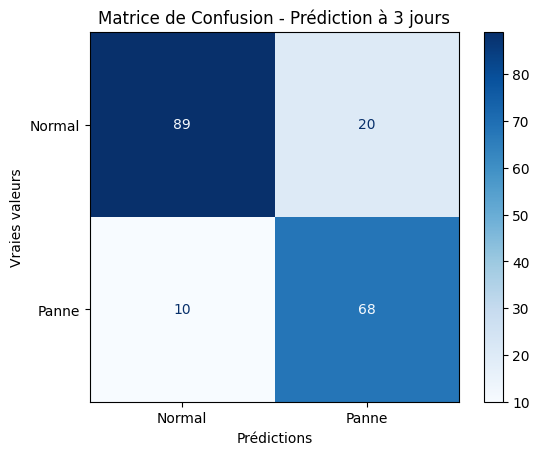

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt

# Supposons que 'data' est déjà chargé avec les données nécessaires

# 1. Calcul de la production attendue pour les panneaux solaires
P_nominale = 300  # Puissance nominale en W
temperature_coeff = -0.340 / 100  # Coefficient de température
irradiance = data['irradiance_direct'] + data['irradiance_diffuse']
temperature = data['temperature']
P_solaire_attendue = P_nominale * (irradiance / 1000) * (1 + temperature_coeff * (temperature - 25))
data['P_solaire_attendue'] = P_solaire_attendue * data['heures_ensoleillement']

# 2. Calcul de l'écart entre production attendue et réelle
data['ecart_production'] = abs(data['P_solaire_attendue'] - data['electricity(PV)']) / data['P_solaire_attendue']
data['comportement_anormal'] = data['ecart_production'].apply(lambda x: 1 if x > 0.5 else 0)

# 3. Ajouter ce comportement comme une caractéristique pour Isolation Forest
X_features = data[['irradiance_direct', 'irradiance_diffuse', 'temperature', 'heures_ensoleillement', 'electricity(PV)', 'comportement_anormal']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# Appliquer Isolation Forest
isolation_forest = IsolationForest(n_estimators=100, contamination=0.15, random_state=42)
data['anomalies'] = isolation_forest.fit_predict(X_scaled)
data['anomalies'] = data['anomalies'].apply(lambda x: 1 if x == -1 else 0)

print(f"Nombre d'anomalies détectées : {data['anomalies'].sum()}")

# 4. Création des lags pour la production et les anomalies
sequence_length = 3
for lag in range(1, sequence_length + 1):
    data[f'lag_production_{lag}'] = data['electricity(PV)'].shift(lag)
    data[f'lag_anomalie_{lag}'] = data['anomalies'].shift(lag)

# Moyenne et écart-type des anomalies sur les 3 derniers jours
data['anomalie_mean'] = data[['lag_anomalie_1', 'lag_anomalie_2', 'lag_anomalie_3']].mean(axis=1)
data['anomalie_std'] = data[['lag_anomalie_1', 'lag_anomalie_2', 'lag_anomalie_3']].std(axis=1)

# Moyenne et écart-type de la production sur les 3 derniers jours
data['production_mean'] = data[['lag_production_1', 'lag_production_2', 'lag_production_3']].mean(axis=1)
data['production_std'] = data[['lag_production_1', 'lag_production_2', 'lag_production_3']].std(axis=1)

# Supprimer les NaN introduits par les lags
data.fillna(0, inplace=True)

# 5. Définir les labels pour prédire les pannes à J+3
data['panne_3jours'] = data['anomalies'].shift(-3).fillna(0).astype(int)

# Détection des anomalies sur 3 jours consécutifs
def detect_anomalies_3days(data):
    data['anomalies_3days'] = data['anomalies'].rolling(window=3).sum().shift(-2)
    data['anomalies_3days'] = data['anomalies_3days'].apply(lambda x: 1 if x == 3 else 0)
    return data

data = detect_anomalies_3days(data)

# 6. Préparation des données pour le modèle supervisé
X_supervised = data[[
    'irradiance_direct', 'irradiance_diffuse', 'temperature', 'heures_ensoleillement',
    'electricity(PV)', 'anomalies', 'anomalies_3days',
    'lag_production_1', 'lag_production_2', 'lag_production_3',
    'production_mean', 'production_std',
]]
y_supervised = data['panne_3jours']

# Rééquilibrage avec SMOTE, division en ensembles d'entraînement et de test
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_supervised, y_supervised)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Entraîner le modèle XGBoost
scale_pos_weight = len(y_train) / sum(y_train == 1)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=42)
xgb_model.fit(X_train, y_train)

# Faire des prédictions
y_pred = xgb_model.predict(X_test)

# 7. Évaluation du modèle
print("Classification Report - Prédiction à 3 jours pour les Panneaux Solaires :")
print(classification_report(y_test, y_pred))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Panne'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Matrice de Confusion - Prédiction à 3 jours')
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.show()


# **Test de prédiction de panne pour le panneau**

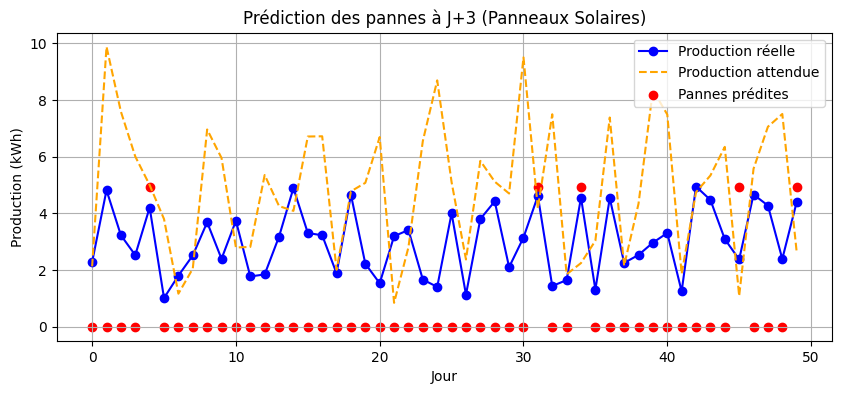

Nombre total de pannes prédites : 5
    electricity(PV)  P_solaire_attendue  anomalies  anomalies_3days  \
0          2.282224            2.128618          0                0   
1          4.819619            9.884130          1                1   
2          3.229704            7.596050          0                0   
3          2.527010            6.010320          0                0   
4          4.206992            5.000592          0                0   
5          1.012950            3.800520          1                0   
6          1.804038            1.166321          0                0   
7          2.517202            2.050273          0                0   
8          3.686365            6.963111          0                0   
9          2.396108            5.955681          0                0   
10         3.741000            2.795215          0                0   
11         1.774446            2.818591          1                0   
12         1.846229            5.355025  

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Générer des données de test simulées
test_data = pd.DataFrame({
    'irradiance_direct': np.random.uniform(0, 2, 50),
    'irradiance_diffuse': np.random.uniform(0, 2, 50),
    'temperature': np.random.uniform(10, 30, 50),
    'heures_ensoleillement': np.random.uniform(4, 12,50),
    'electricity(PV)': np.random.uniform(1, 5,50)
})


# Calculer la production attendue
P_nominale = 300  # Puissance nominale en W
temperature_coeff = -0.340 / 100
irradiance = test_data['irradiance_direct'] + test_data['irradiance_diffuse']
temperature = test_data['temperature']
P_solaire_attendue = P_nominale * (irradiance / 1000) * (1 + temperature_coeff * (temperature - 25))
test_data['P_solaire_attendue'] = P_solaire_attendue * test_data['heures_ensoleillement']

# Calculer l'écart de production
test_data['ecart_production'] = abs(test_data['P_solaire_attendue'] - test_data['electricity(PV)']) / test_data['P_solaire_attendue']
test_data['comportement_anormal'] = test_data['ecart_production'].apply(lambda x: 1 if x > 0.5 else 0)

# Normaliser les données
X_test_features = test_data[['irradiance_direct', 'irradiance_diffuse', 'temperature', 'heures_ensoleillement', 'electricity(PV)', 'comportement_anormal']]
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test_features)

# Détection des anomalies avec Isolation Forest
isolation_forest = IsolationForest(n_estimators=100, contamination=0.15, random_state=42)
test_data['anomalies'] = isolation_forest.fit_predict(X_test_scaled)
test_data['anomalies'] = test_data['anomalies'].apply(lambda x: 1 if x == -1 else 0)

# Création des lags pour les données de test
sequence_length = 3
for lag in range(1, sequence_length + 1):
    test_data[f'lag_production_{lag}'] = test_data['electricity(PV)'].shift(lag)
test_data['production_mean'] = test_data[['lag_production_1', 'lag_production_2', 'lag_production_3']].mean(axis=1)
test_data['production_std'] = test_data[['lag_production_1', 'lag_production_2', 'lag_production_3']].std(axis=1)

def check_anomalies_3days(row):
    if row['anomalies'] == 1 and row['production_mean'] < row['P_solaire_attendue'] * 0.5:
        return 1
    return 0

# Calcul des anomalies sur 3 jours dans les données de test
test_data['anomalies_3days'] = test_data.apply(check_anomalies_3days, axis=1)

test_data.fillna(0, inplace=True)

# Préparation des données pour les prédictions supervisées
X_test_supervised = test_data[[
    'irradiance_direct', 'irradiance_diffuse', 'temperature', 'heures_ensoleillement',
    'electricity(PV)', 'anomalies', 'anomalies_3days',
    'lag_production_1', 'lag_production_2', 'lag_production_3',
    'production_mean', 'production_std'
]]

# Faire des prédictions avec le modèle XGBoost
y_test_predictions = xgb_model.predict(X_test_supervised)

# Ajouter les prédictions aux données de test
test_data['panne_predite'] = y_test_predictions

# Visualisation des résultats
plt.figure(figsize=(10, 4))
plt.plot(test_data.index, test_data['electricity(PV)'], label='Production réelle', marker='o', color='blue')
plt.plot(test_data.index, test_data['P_solaire_attendue'], label='Production attendue', linestyle='--', color='orange')
plt.scatter(test_data.index, test_data['panne_predite'] * test_data['electricity(PV)'].max(), color='red', label='Pannes prédites')
plt.title('Prédiction des pannes à J+3 (Panneaux Solaires)')
plt.xlabel('Jour')
plt.ylabel('Production (kWh)')
plt.legend()
plt.grid()
plt.show()

# Résumé des résultats
print(f"Nombre total de pannes prédites : {test_data['panne_predite'].sum()}")
print(test_data[['electricity(PV)', 'P_solaire_attendue', 'anomalies', 'anomalies_3days', 'panne_predite']])




# **l'éolien**

<ipython-input-18-64c7e6649af2>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['ecart_relatif'].replace([np.inf, -np.inf], np.nan, inplace=True)


Nombre d'anomalies détectées pour l'éolienne : 20


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:21:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report - Prédiction à 3 jours pour l'Éolienne :
              precision    recall  f1-score   support

           0       0.73      0.64      0.68        25
           1       0.65      0.74      0.69        23

    accuracy                           0.69        48
   macro avg       0.69      0.69      0.69        48
weighted avg       0.69      0.69      0.69        48



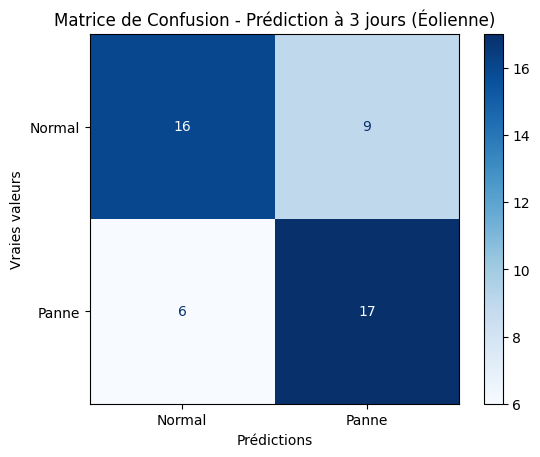

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
# 1. Calcul de la production attendue pour l'éolienne
rho = 1.225  # Densité de l'air en kg/m^3
A = np.pi * (1.5**2)  # Surface balayée par les pales en m² (1.5m de rayon)
Cp = 0.4  # Coefficient de performance de l'éolienne
V = data['WS50M']
P_eolienne_attendue = 0.5 * rho * A * (V**3) * Cp
data['P_eolienne_attendue'] = P_eolienne_attendue * data['heures_vent']

# 2. Calcul de l'écart relatif entre l'énergie attendue et l'énergie produite
data['ecart_relatif'] = abs(data['P_eolienne_attendue'] - data['electricity(eolienne)']) / data['P_eolienne_attendue']

# Gérer les valeurs infinies ou NaN
data['ecart_relatif'].replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(0, inplace=True)

# Identifier les anomalies basées sur un seuil
data['ecart_anormal'] = data['ecart_relatif'].apply(lambda x: 1 if x > 0.5 else 0)

# 3. Détection des anomalies avec Isolation Forest
X_eolienne_features = data[['WS50M', 'heures_vent', 'P_eolienne_attendue', 'electricity(eolienne)', 'ecart_relatif', 'ecart_anormal']]
scaler = StandardScaler()
X_eolienne_scaled = scaler.fit_transform(X_eolienne_features)

contamination_eolienne = 0.20  # Taux de contamination pour l'éolienne
model_eolienne = IsolationForest(n_estimators=100, contamination=contamination_eolienne, random_state=42)
data['anomalies_eolienne'] = model_eolienne.fit_predict(X_eolienne_scaled)
data['anomalies_eolienne'] = data['anomalies_eolienne'].apply(lambda x: 1 if x == -1 else 0)

print(f"Nombre d'anomalies détectées pour l'éolienne : {data['anomalies_eolienne'].sum()}")

# Continuer avec les étapes suivantes...


# Détection des anomalies successives sur 3 jours
def detect_anomalies_3days(data):
    data['anomalies_3days'] = data['anomalies_eolienne'].rolling(window=3).sum().shift(-2)
    data['anomalies_3days'] = data['anomalies_3days'].apply(lambda x: 1 if x == 3 else 0)
    return data

data = detect_anomalies_3days(data)

# 3. Création des caractéristiques temporelles et des labels supervisés
sequence_length = 3  # Historique de 3 jours
for lag in range(1, sequence_length + 1):
    data[f'lag_production_{lag}_eolienne'] = data['electricity(eolienne)'].shift(lag)
    data[f'lag_anomalies_{lag}_eolienne'] = data['anomalies_eolienne'].shift(lag)

# Moyenne et écart-type des anomalies et de la production sur les 3 derniers jours
data['rolling_mean_production_eolienne'] = data[[f'lag_production_{i}_eolienne' for i in range(1, sequence_length + 1)]].mean(axis=1)
data['rolling_std_production_eolienne'] = data[[f'lag_production_{i}_eolienne' for i in range(1, sequence_length + 1)]].std(axis=1)

# Créer les labels pour prédire les pannes à J+3
data['panne_3jours_eolienne'] = data['anomalies_eolienne'].shift(-3).fillna(0).astype(int)

# Supprimer les NaN introduits par les décalages
data.fillna(0, inplace=True)

# 4. Sélectionner les caractéristiques pour le modèle supervisé
X_supervised_eolienne = data[[
    'WS50M', 'heures_vent', 'P_eolienne_attendue', 'electricity(eolienne)', 'ecart_relatif', 'ecart_anormal',
    'lag_production_1_eolienne', 'lag_production_2_eolienne', 'lag_production_3_eolienne',
    'rolling_mean_production_eolienne', 'rolling_std_production_eolienne',
    'anomalies_3days'
]]
y_supervised_eolienne = data['panne_3jours_eolienne']

# Rééquilibrage avec SMOTE
smote = SMOTE(random_state=42)
X_resampled_eolienne, y_resampled_eolienne = smote.fit_resample(X_supervised_eolienne, y_supervised_eolienne)

# Division en ensembles d'entraînement et de test
X_train_eolienne, X_test_eolienne, y_train_eolienne, y_test_eolienne = train_test_split(
    X_resampled_eolienne, y_resampled_eolienne, test_size=0.3, random_state=42)

# Modèle XGBoost pour la classification
scale_pos_weight_eolienne = len(y_train_eolienne) / sum(y_train_eolienne == 1)  # Ajuster le poids des classes
xgb_model_eolienne = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight_eolienne, random_state=42)
xgb_model_eolienne.fit(X_train_eolienne, y_train_eolienne)

# Prédictions
y_pred_eolienne = xgb_model_eolienne.predict(X_test_eolienne)

# Évaluation du modèle
print("Classification Report - Prédiction à 3 jours pour l'Éolienne :")
print(classification_report(y_test_eolienne, y_pred_eolienne))

# Matrice de confusion
conf_matrix_eolienne = confusion_matrix(y_test_eolienne, y_pred_eolienne)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_eolienne, display_labels=['Normal', 'Panne'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Matrice de Confusion - Prédiction à 3 jours (Éolienne)')
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.show()


# **Batterie**

Nombre d'anomalies détectées pour la batterie : 37
Distribution des classes pour les pannes (batterie) :
panne_3jours_batterie
0    329
1     36
Name: count, dtype: int64
Classification Report - Prédiction à 3 jours pour la Batterie :
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       105
           1       0.88      0.96      0.92        93

    accuracy                           0.92       198
   macro avg       0.92      0.92      0.92       198
weighted avg       0.92      0.92      0.92       198



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:25:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


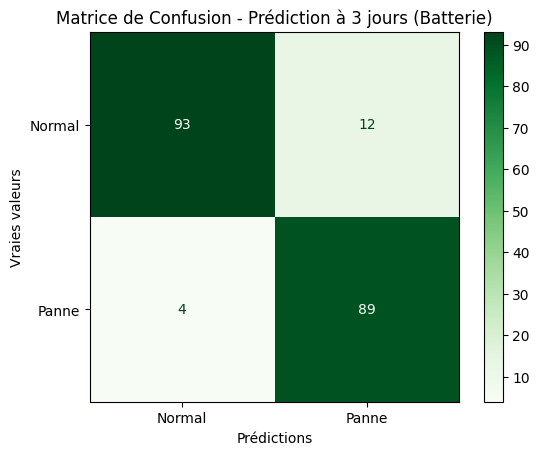

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt

# Ajouter des colonnes pour indiquer si la tension et le courant sont hors seuils
data['voltage_anomaly'] = data['battery_voltage'].apply(lambda v: 1 if v < 21.6 or v > 25.6 else 0)
data['current_anomaly'] = data['battery_current'].apply(lambda c: 1 if c > 40 else 0)

# Inclure les anomalies des seuils dans les caractéristiques pour Isolation Forest
X_batterie_features = data[['battery_voltage', 'battery_current', 'voltage_anomaly', 'current_anomaly']]
scaler = StandardScaler()
X_batterie_scaled = scaler.fit_transform(X_batterie_features)

# Appliquer Isolation Forest
contamination_batterie = 0.10
model_batterie = IsolationForest(n_estimators=100, contamination=contamination_batterie, random_state=42)
data['anomalies_batterie'] = model_batterie.fit_predict(X_batterie_scaled)
data['anomalies_batterie'] = data['anomalies_batterie'].apply(lambda x: 1 if x == -1 else 0)

print(f"Nombre d'anomalies détectées pour la batterie : {data['anomalies_batterie'].sum()}")

# Détection des anomalies successives sur 3 jours
def detect_anomalies_3days(data):
    data['anomalies_3days'] = data['anomalies_batterie'].rolling(window=3).sum().shift(-2)
    data['anomalies_3days'] = data['anomalies_3days'].apply(lambda x: 1 if x == 3 else 0)
    return data

data = detect_anomalies_3days(data)

# 2. Création des caractéristiques temporelles et des labels supervisés
sequence_length = 3  # Historique de 3 jours
for lag in range(1, sequence_length + 1):
    data[f'lag_voltage_{lag}_batterie'] = data['battery_voltage'].shift(lag)
    data[f'lag_current_{lag}_batterie'] = data['battery_current'].shift(lag)
    data[f'lag_anomalies_{lag}_batterie'] = data['anomalies_batterie'].shift(lag)

# Moyenne et écart-type des anomalies, voltage et courant sur les 3 derniers jours
data['rolling_mean_voltage_batterie'] = data[[f'lag_voltage_{i}_batterie' for i in range(1, sequence_length + 1)]].mean(axis=1)
data['rolling_std_voltage_batterie'] = data[[f'lag_voltage_{i}_batterie' for i in range(1, sequence_length + 1)]].std(axis=1)
data['rolling_mean_current_batterie'] = data[[f'lag_current_{i}_batterie' for i in range(1, sequence_length + 1)]].mean(axis=1)
data['rolling_std_current_batterie'] = data[[f'lag_current_{i}_batterie' for i in range(1, sequence_length + 1)]].std(axis=1)
data['rolling_mean_anomalies_batterie'] = data[[f'lag_anomalies_{i}_batterie' for i in range(1, sequence_length + 1)]].mean(axis=1)

# Créer les labels pour prédire les pannes à J+3
data['panne_3jours_batterie'] = data['anomalies_batterie'].shift(-3).fillna(0).astype(int)

# Supprimer les NaN introduits par les décalages
data.fillna(0, inplace=True)

# 3. Sélectionner les caractéristiques pour le modèle supervisé
X_supervised_batterie = data[[
    'battery_voltage', 'battery_current',
    'lag_voltage_1_batterie', 'lag_voltage_2_batterie', 'lag_voltage_3_batterie',
    'lag_current_1_batterie', 'lag_current_2_batterie', 'lag_current_3_batterie',
    'rolling_mean_voltage_batterie', 'rolling_std_voltage_batterie',
    'rolling_mean_current_batterie', 'rolling_std_current_batterie',
    'lag_anomalies_1_batterie', 'lag_anomalies_2_batterie', 'lag_anomalies_3_batterie',
    'rolling_mean_anomalies_batterie', 'anomalies_batterie', 'anomalies_3days'
]]
y_supervised_batterie = data['panne_3jours_batterie']

# Vérifier la distribution des classes
print("Distribution des classes pour les pannes (batterie) :")
print(y_supervised_batterie.value_counts())

# 4. Rééquilibrage des classes avec SMOTE
smote = SMOTE(random_state=42)
X_resampled_batterie, y_resampled_batterie = smote.fit_resample(X_supervised_batterie, y_supervised_batterie)

# 5. Division des données en ensembles d'entraînement et de test
X_train_batterie, X_test_batterie, y_train_batterie, y_test_batterie = train_test_split(
    X_resampled_batterie, y_resampled_batterie, test_size=0.3, random_state=42)

# 6. Modèle XGBoost pour la classification
scale_pos_weight_batterie = len(y_train_batterie) / sum(y_train_batterie == 1)  # Ajuster le poids des classes
xgb_model_batterie = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight_batterie, random_state=42)
xgb_model_batterie.fit(X_train_batterie, y_train_batterie)
y_pred_batterie = xgb_model_batterie.predict(X_test_batterie)

# 7. Évaluation du modèle
print("Classification Report - Prédiction à 3 jours pour la Batterie :")
print(classification_report(y_test_batterie, y_pred_batterie))

# Matrice de confusion
conf_matrix_batterie = confusion_matrix(y_test_batterie, y_pred_batterie)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_batterie, display_labels=['Normal', 'Panne'])
disp.plot(cmap='Greens', values_format='d')
plt.title('Matrice de Confusion - Prédiction à 3 jours (Batterie)')
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.show()


# **LED**

Nombre d'anomalies détectées pour les LEDs : 19
Distribution des classes pour les pannes (LEDs) :
panne_3jours_led
0    347
1     18
Name: count, dtype: int64
Classification Report - Prédiction à 3 jours pour les LEDs :
              precision    recall  f1-score   support

           0       0.99      0.85      0.91       117
           1       0.83      0.99      0.91        92

    accuracy                           0.91       209
   macro avg       0.91      0.92      0.91       209
weighted avg       0.92      0.91      0.91       209



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:34:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


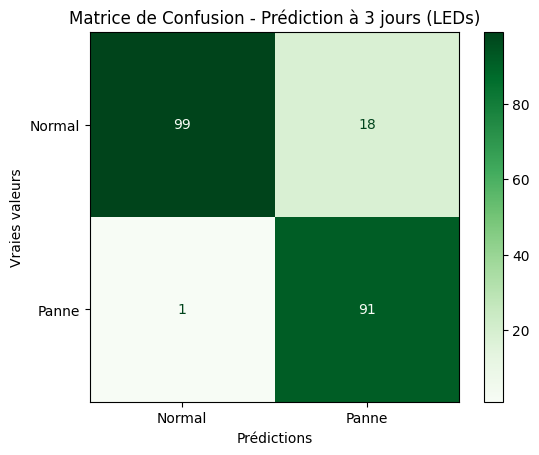

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt

# 1. Détection des anomalies avec Isolation Forest (non supervisé)
X_led_features = data[['led_current', 'led_surge']]
scaler = StandardScaler()
X_led_scaled = scaler.fit_transform(X_led_features)

contamination_led = 0.05  # Taux de contamination pour les LEDs
model_led = IsolationForest(n_estimators=100, contamination=contamination_led, random_state=42)
data['anomalies_led'] = model_led.fit_predict(X_led_scaled)
data['anomalies_led'] = data['anomalies_led'].apply(lambda x: 1 if x == -1 else 0)

print(f"Nombre d'anomalies détectées pour les LEDs : {data['anomalies_led'].sum()}")

# 2. Création des caractéristiques temporelles et des labels supervisés
sequence_length = 3  # Historique de 3 jours
for lag in range(1, sequence_length + 1):
    data[f'lag_current_{lag}_led'] = data['led_current'].shift(lag)
    data[f'lag_surge_{lag}_led'] = data['led_surge'].shift(lag)
    data[f'lag_anomalies_{lag}_led'] = data['anomalies_led'].shift(lag)

# Moyenne et écart-type des caractéristiques sur les 3 derniers jours
data['rolling_mean_current_led'] = data[[f'lag_current_{i}_led' for i in range(1, sequence_length + 1)]].mean(axis=1)
data['rolling_std_current_led'] = data[[f'lag_current_{i}_led' for i in range(1, sequence_length + 1)]].std(axis=1)
data['rolling_mean_surge_led'] = data[[f'lag_surge_{i}_led' for i in range(1, sequence_length + 1)]].mean(axis=1)
data['rolling_std_surge_led'] = data[[f'lag_surge_{i}_led' for i in range(1, sequence_length + 1)]].std(axis=1)
data['rolling_mean_anomalies_led'] = data[[f'lag_anomalies_{i}_led' for i in range(1, sequence_length + 1)]].mean(axis=1)

# Détection des anomalies successives sur 3 jours
def detect_anomalies_3days(data):
    data['anomalies_3days_led'] = data['anomalies_led'].rolling(window=3).sum().shift(-2)
    data['anomalies_3days_led'] = data['anomalies_3days_led'].apply(lambda x: 1 if x == 3 else 0)
    return data

data = detect_anomalies_3days(data)

# Créer les labels pour prédire les pannes à J+3
data['panne_3jours_led'] = data['anomalies_led'].shift(-3).fillna(0).astype(int)

# Supprimer les NaN introduits par les décalages
data.fillna(0, inplace=True)

# 3. Sélectionner les caractéristiques pour le modèle supervisé
X_supervised_led = data[[
    'led_current', 'led_surge',
    'lag_current_1_led', 'lag_current_2_led', 'lag_current_3_led',
    'lag_surge_1_led', 'lag_surge_2_led', 'lag_surge_3_led',
    'rolling_mean_current_led', 'rolling_std_current_led',
    'rolling_mean_surge_led', 'rolling_std_surge_led',
    'lag_anomalies_1_led', 'lag_anomalies_2_led', 'lag_anomalies_3_led',
    'rolling_mean_anomalies_led', 'anomalies_3days_led'
]]
y_supervised_led = data['panne_3jours_led']

# Vérifier la distribution des classes
print("Distribution des classes pour les pannes (LEDs) :")
print(y_supervised_led.value_counts())

# 4. Rééquilibrage des classes avec SMOTE
smote = SMOTE(random_state=42)
X_resampled_led, y_resampled_led = smote.fit_resample(X_supervised_led, y_supervised_led)

# 5. Division des données en ensembles d'entraînement et de test
X_train_led, X_test_led, y_train_led, y_test_led = train_test_split(
    X_resampled_led, y_resampled_led, test_size=0.3, random_state=42)

# 6. Modèle XGBoost pour la classification
scale_pos_weight_led = len(y_train_led) / sum(y_train_led == 1)  # Ajuster le poids des classes
xgb_model_led = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight_led, random_state=42)
xgb_model_led.fit(X_train_led, y_train_led)
y_pred_led = xgb_model_led.predict(X_test_led)

# 7. Évaluation du modèle
print("Classification Report - Prédiction à 3 jours pour les LEDs :")
print(classification_report(y_test_led, y_pred_led))

# Matrice de confusion
conf_matrix_led = confusion_matrix(y_test_led, y_pred_led)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_led, display_labels=['Normal', 'Panne'])
disp.plot(cmap='Greens', values_format='d')
plt.title('Matrice de Confusion - Prédiction à 3 jours (LEDs)')
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.show()
